From [here](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/).

## Data cleaning

In [9]:
import numpy as np

In [10]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('data/raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)

In [11]:
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('data/pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [4]:
print(dataset.shape)
dataset.head()

(43800, 8)


,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


## Keras model

In [5]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [47]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [7]:
values = dataset.values

`values` is the whole dataset, X and Y. Pollution is the first column. Looking at the first five rows:

In [8]:
values[:5, :]

array([[129.0, -16, -4.0, 1020.0, 'SE', 1.79, 0, 0],
       [148.0, -15, -4.0, 1020.0, 'SE', 2.68, 0, 0],
       [159.0, -11, -5.0, 1021.0, 'SE', 3.57, 0, 0],
       [181.0, -7, -5.0, 1022.0, 'SE', 5.36, 1, 0],
       [138.0, -7, -5.0, 1022.0, 'SE', 6.25, 2, 0]], dtype=object)

In [9]:
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

In [10]:
values[:5, :]

array([[129.0, -16, -4.0, 1020.0, 2, 1.79, 0, 0],
       [148.0, -15, -4.0, 1020.0, 2, 2.68, 0, 0],
       [159.0, -11, -5.0, 1021.0, 2, 3.57, 0, 0],
       [181.0, -7, -5.0, 1022.0, 2, 5.36, 1, 0],
       [138.0, -7, -5.0, 1022.0, 2, 6.25, 2, 0]], dtype=object)

In [19]:
# ensure all data is float
values = values.astype('float32')

In [11]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Note that when we apply the `scaler`, we have Y in the first column, and the rest of the dataset as X.

In [45]:
scaled.shape

(43800, 8)

In [12]:
np.round(scaled,2)[:5, :]

array([[0.13, 0.35, 0.25, 0.53, 0.67, 0.  , 0.  , 0.  ],
       [0.15, 0.37, 0.25, 0.53, 0.67, 0.  , 0.  , 0.  ],
       [0.16, 0.43, 0.23, 0.55, 0.67, 0.01, 0.  , 0.  ],
       [0.18, 0.49, 0.23, 0.56, 0.67, 0.01, 0.04, 0.  ],
       [0.14, 0.49, 0.23, 0.56, 0.67, 0.01, 0.07, 0.  ]])

In [13]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [46]:
print(reframed.shape)
reframed.head()

(43799, 9)


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545455,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563636,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563636,0.666667,0.009912,0.074074,0.0,0.109658


Now our dependent variable is the _last_ column in the dataset.

In [15]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545455   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563636   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563636   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [17]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
print(n_train_hours)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

8760


In [42]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


Breakdown of what `train_x` is: 

* Each "x" observation is a _sequence of vectors_ and each "y" observation is a sequence.
* Here, each "x" observation is a sequence of length 1, and each timestep is of length 8.


In [20]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

What's going on?

An LSTM, if we pass in data of:

* $t$ timesteps, where each timestep has dimension $n$.

The LSTM layer must return a vector of $t$ timesteps as well. However, each timestep can be encoded with whatever dimensionality we want; above, we specify 50.

So, assuming we are feeding in one observation at a time:

* The LSTM layer here takes as input an 1 x 8 vector, representing 1 time step, and 8 features for each time step.
* It outputs a 1 x 50 tensor, where the 50 represent 50 "neurons".

Then this 1 x 50 tensor is fed through a fully connected layer to get a single output number.

In [ ]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 2s - loss: 0.0697 - val_loss: 0.0546
Epoch 2/50
 - 1s - loss: 0.0476 - val_loss: 0.0531
Epoch 3/50
 - 1s - loss: 0.0319 - val_loss: 0.0378
Epoch 4/50
 - 1s - loss: 0.0200 - val_loss: 0.0255
Epoch 5/50
 - 1s - loss: 0.0162 - val_loss: 0.0169
Epoch 6/50
 - 1s - loss: 0.0150 - val_loss: 0.0151
Epoch 7/50
 - 1s - loss: 0.0148 - val_loss: 0.0144
Epoch 8/50
 - 1s - loss: 0.0149 - val_loss: 0.0138
Epoch 9/50
 - 1s - loss: 0.0150 - val_loss: 0.0137
Epoch 10/50
 - 1s - loss: 0.0149 - val_loss: 0.0134
Epoch 11/50
 - 1s - loss: 0.0149 - val_loss: 0.0138
Epoch 12/50
 - 1s - loss: 0.0146 - val_loss: 0.0137
Epoch 13/50
 - 1s - loss: 0.0146 - val_loss: 0.0134
Epoch 14/50
 - 1s - loss: 0.0147 - val_loss: 0.0136
Epoch 15/50
 - 1s - loss: 0.0146 - val_loss: 0.0134
Epoch 16/50
 - 1s - loss: 0.0146 - val_loss: 0.0134
Epoch 17/50
 - 1s - loss: 0.0145 - val_loss: 0.0134
Epoch 18/50
 - 1s - loss: 0.0145 - val_loss: 0.0134
Epoch 19/50
 - 1s - loss

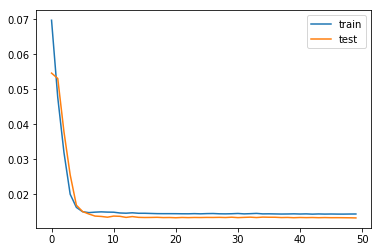

In [21]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [54]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [44]:
test_X.shape

(35039, 1, 8)

In [37]:
print(np.max(yhat))
print(np.min(yhat))

0.94157815
-0.013155606


In [30]:
yhat.shape

(35039, 1)

In [29]:
test_X.shape

(35039, 8)

In [41]:
test_X

array([[0.0362173 , 0.33823529, 0.19672131, ..., 0.12757413, 0.        ,
        0.        ],
       [0.03118712, 0.33823529, 0.19672131, ..., 0.006101  , 0.        ,
        0.        ],
       [0.02012072, 0.33823529, 0.19672131, ..., 0.0145091 , 0.        ,
        0.        ],
       ...,
       [0.01006036, 0.26470588, 0.26229508, ..., 0.40558831, 0.        ,
        0.        ],
       [0.01006036, 0.26470588, 0.26229508, ..., 0.41399641, 0.        ,
        0.        ],
       [0.00804829, 0.26470588, 0.24590164, ..., 0.42086644, 0.        ,
        0.        ]])

In [55]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
print(inv_yhat)
print(inv_yhat.shape)

[[0.03533243 0.33823529 0.19672131 ... 0.12757413 0.         0.        ]
 [0.03168434 0.33823529 0.19672131 ... 0.006101   0.         0.        ]
 [0.02108669 0.33823529 0.19672131 ... 0.0145091  0.         0.        ]
 ...
 [0.00941326 0.26470588 0.26229508 ... 0.40558831 0.         0.        ]
 [0.00940368 0.26470588 0.26229508 ... 0.41399641 0.         0.        ]
 [0.00765015 0.26470588 0.24590164 ... 0.42086644 0.         0.        ]]
(35039, 8)


**Note:** Originally the dataset had Y as its first column. Here, we are restoring that by concatenating with X.

In [56]:
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [57]:
inv_yhat

array([35.12043928, 31.49423301, 20.96017265, ...,  9.3567777 ,
        9.34725467,  7.60425325])

In [58]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

Note: this is the same operation as above but applied to the scaled actual values of Y instead of the predictions.

In [59]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.289


## Multiple lag timesteps version

**Same** imports as before:

In [12]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

**Same** basic preprocessing as before:

In [30]:
# load dataset
dataset = read_csv('data/pollution.csv', header=0, index_col=0)
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


This is our starting point. We want to reshape to get in a form suitable for time series. 

We want the first "observation" "X" value to be a _matrix_ of `T` time steps x features:

In [13]:
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

**Same** basic preprocessing as before:

In [14]:
# specify the number of lag hours
n_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

**Strategy, step 1:** Reshape so that each row has the data we want, even if it isn't in the right shape. 

For example, row #1 has all eight features across three time steps. 

This just involves creating new columns based on shifted versions of the DataFrame and so on. See the `series_to_supervised` function for details.

The number of rows is the final number of observations we want!

**Difference** is now that we have three timesteps going backwards into the past:

In [22]:
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
3,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,...,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,...,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,...,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0
6,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,...,0.111111,0.0,0.105634,0.485294,0.213115,0.581818,0.666667,0.014492,0.148148,0.0
7,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,...,0.148148,0.0,0.124748,0.485294,0.229508,0.600000,0.666667,0.017551,0.000000,0.0


**Same** as before

In [16]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
print(n_train_hours)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

8760


In [17]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(8760, 24) 8760 (8760,)


Here, we take the data generated above (see `reframed`) and we:

* Keep the first dimension the same, since the number of rows we have is identical to the number of observations we need. 
* Reshape the last two dimensions: turn a 24 element row into (time steps x features)

### Aside on reshaping

In [39]:
a = np.random.rand(5, 6)
a

array([[0.13731265, 0.00182499, 0.07147533, 0.79690608, 0.18786311,
        0.89540542],
       [0.26190566, 0.57249142, 0.92041008, 0.9408114 , 0.15981154,
        0.82863763],
       [0.64869249, 0.28997308, 0.27184602, 0.91498136, 0.54588793,
        0.32596998],
       [0.83942756, 0.71269026, 0.55255506, 0.93893773, 0.10296862,
        0.6852757 ],
       [0.04418897, 0.88061887, 0.09511251, 0.84512999, 0.1912083 ,
        0.33945139]])

In [41]:
a.reshape(5, 2, 3)

array([[[0.13731265, 0.00182499, 0.07147533],
        [0.79690608, 0.18786311, 0.89540542]],

       [[0.26190566, 0.57249142, 0.92041008],
        [0.9408114 , 0.15981154, 0.82863763]],

       [[0.64869249, 0.28997308, 0.27184602],
        [0.91498136, 0.54588793, 0.32596998]],

       [[0.83942756, 0.71269026, 0.55255506],
        [0.93893773, 0.10296862, 0.6852757 ]],

       [[0.04418897, 0.88061887, 0.09511251],
        [0.84512999, 0.1912083 , 0.33945139]]])

Note that this keeps the first dimension intact and only reshapes the last two dimensions, which is what we want.

In [18]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

**Key difference**: Now, each observation of X that will be fed into the LSTM to make a prediction is:

* Three time steps
* Eight features being fed in at each time step

Conceptually, that's fine. In terms of our data, that means that we need an array where: 

* The first dimension indexes our observations
* The other two dimensions are the vectors we are feeding in
    * In Keras, by default, it assumes our data is structured as rows, just like, if we had a time series dataset, we would have time steps as rows and features as columns. So, since we have 3 time steps and 8 features for each observation, each observation has three rows and eight columns.

In [28]:
train_X[0, :, :].shape

(3, 8)

Train on 8760 samples, validate on 35037 samples
Epoch 1/50
 - 3s - loss: 0.0508 - val_loss: 0.0362
Epoch 2/50
 - 1s - loss: 0.0260 - val_loss: 0.0230
Epoch 3/50
 - 1s - loss: 0.0210 - val_loss: 0.0193
Epoch 4/50
 - 1s - loss: 0.0211 - val_loss: 0.0188
Epoch 5/50
 - 1s - loss: 0.0204 - val_loss: 0.0184
Epoch 6/50
 - 1s - loss: 0.0199 - val_loss: 0.0187
Epoch 7/50
 - 1s - loss: 0.0193 - val_loss: 0.0181
Epoch 8/50
 - 1s - loss: 0.0189 - val_loss: 0.0177
Epoch 9/50
 - 1s - loss: 0.0186 - val_loss: 0.0176
Epoch 10/50
 - 1s - loss: 0.0182 - val_loss: 0.0175
Epoch 11/50
 - 1s - loss: 0.0178 - val_loss: 0.0167
Epoch 12/50
 - 1s - loss: 0.0175 - val_loss: 0.0163
Epoch 13/50
 - 1s - loss: 0.0169 - val_loss: 0.0159
Epoch 14/50
 - 1s - loss: 0.0166 - val_loss: 0.0168
Epoch 15/50
 - 1s - loss: 0.0163 - val_loss: 0.0163
Epoch 16/50
 - 1s - loss: 0.0158 - val_loss: 0.0163
Epoch 17/50
 - 1s - loss: 0.0158 - val_loss: 0.0162
Epoch 18/50
 - 1s - loss: 0.0152 - val_loss: 0.0163
Epoch 19/50
 - 1s - loss

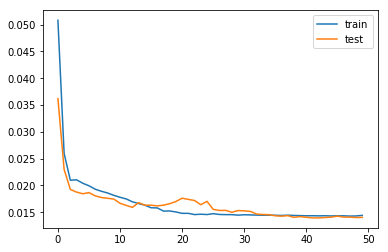

In [19]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [20]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.674
